In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input 
from tensorflow.keras.layers import Conv1D, Flatten, MaxPooling1D, UpSampling1D, Reshape, Concatenate, Multiply, Lambda
from tensorflow.keras.backend import int_shape
from keras import backend as bken
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from keras.callbacks import LearningRateScheduler
import keras
from keras import layers
from tensorflow.keras.backend import int_shape
import os
from scipy.special import comb

### Read dataset

In [78]:
df = pd.read_pickle('pd_data_dp_subset.p')

# ---- recast event_id to int
df["event_id"] = df["event_id"].apply(lambda x:int(x))

### Header
    1. P_wave_processed: pre-processed p-wave recordings, each of them has dim = (600, 3)
    2. P_wave_amplitudes: max(amplitude) of raw p-wave recordings, each of them has dim = (3,)
    3. azimuth: the azimuth of earthquake with respect to station
    4. station_name: name of the station
    5. station_network: netowrk code of the station
    6. event_id: event id
    7. depth: event depth
    8. station_lat: station coordinate lat.
    9. station_long: station coordinate long.
    10. event_lat: event coordinate lat
    11. event_long: event coordinate long
    12. magnitude: event magnitude
    13. P: phase arrival time at station
    14. delta: event station distance in degree (1 degree ~= 111 km)

In [79]:
df.head(3)

,station_name,station_network,station_lat,station_long,event_id,event_time,event_lat,event_long,depth,P_wave_processed,azimuth,delta,phase,P,magnitude
0,AAK,II,42.637500,74.494200,1725583,9.470968e+08,-9.131,109.579,35.0,"[[4.5132976810436585e-17, 0.0, -5.126423482750...",330.887,60.666,P,9.470974e+08,5.6
1,AAK,KN,42.633301,74.494400,1725583,9.470968e+08,-9.131,109.579,35.0,"[[-0.004384802184109918, 0.002776395732707534,...",330.887,60.666,P,9.470974e+08,5.6
2,AML,KN,42.131100,73.694099,1725583,9.470968e+08,-9.131,109.579,35.0,"[[-0.003072967942240945, 0.002691759337183582,...",329.993,60.675,P,9.470974e+08,5.6


### Some facts of the dataset

In [80]:
total_entries = df.shape[0]
print(f"total {total_entries} entries")
event_number = pd.unique(df.event_id).shape[0]
print(f"total {event_number} events")
station_number = pd.unique(df.station_name).shape[0]
print(f"total ~{station_number} stations")
min_distance = df.delta.min()
max_distance = df.delta.max()
median_distance = df.delta.median()
print(f"min station-event distance {min_distance:.3f} degree")
print(f"max station-event distance {max_distance:.3f} degree")
print(f"median station-event distance {median_distance:.3f} degree")

total 145677 entries
total 1295 events
total ~1574 stations
min station-event distance 0.199 degree
max station-event distance 90.866 degree
median station-event distance 68.233 degree


### Split train and test set
To prevent data leaking from one event to another one, we will split dataset by event

In [84]:
# Group by event and aggregate relevant columns
df_evt_grouped = df.groupby('event_id').agg(
    {'station_name': lambda x:list(x),
     'station_network': lambda x:list(x),
     'station_lat': lambda x:list(x),
     'station_long': lambda x:list(x),
     'P_wave_processed': lambda x:np.asarray(list(x))
    }).reset_index()
df_evt_grouped["num_waves"] = df_evt_grouped["P_wave_processed"]\
                              .apply(lambda x: x.shape[0])

# ---- drop events that only has one recording
df_evt_grouped = df_evt_grouped[df_evt_grouped.num_waves>=2]

In [85]:
# Split train and test sets
train_set, test_set, _, _ = train_test_split(df_evt_grouped, 
                                             df_evt_grouped, 
                                             test_size=0.2, 
                                             random_state=42)

In [86]:
num_train_events = train_set.shape[0]
num_train_waves = train_set.num_waves.sum()
num_test_events = test_set.shape[0]
num_test_waves = test_set.num_waves.sum()
print(f"Number of train event: {num_train_events}")
print(f"Number of train waves: {num_train_waves}")
print(f"Number of test event: {num_test_events}")
print(f"Number of test waves: {num_test_waves}")

Number of train event: 1034
Number of train waves: 117692
Number of test event: 259
Number of test waves: 27983


### Data for  the Resnet style Autoencoder

In [8]:
df_train_set_flat = df_evt_grouped.explode(['P_wave_processed'])

In [9]:
waves_train = np.asarray((df_train_set_flat.P_wave_processed.to_list()))

In [10]:
#df_evt_grouped[["event_id","P_wave_processed"]].explode(['P_wave_processed'])

### Model 1. 1D-Resnet style autoencoder

In [11]:
def identity_block(x, num_filters=64, kernel_size=5):
    
    # copy tensor to variable called x_skip
    x_skip = x
    
    # Layer 1
    x = tf.keras.layers.Conv1D(num_filters, kernel_size, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Layer 2
    x = tf.keras.layers.Conv1D(num_filters, kernel_size, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [12]:
def reverse_identity_block(x, num_filters=64, kernel_size=5):
    
    # copy tensor to variable called x_skip
    x_skip = x
    
    # Layer 1
    x = tf.keras.layers.Conv1DTranspose(num_filters, kernel_size, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Layer 2
    x = tf.keras.layers.Conv1DTranspose(num_filters, kernel_size, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [13]:
def ResAutoencoder(x_input_shape=(600,3),
                   encoding_dim=100,
                   num_res_blocks=9, 
                   max_pool_itval=3,
                   pooling_dim = 2):
    
    # ============================================ #
    # ============= Define the ENCODER =========== #
    # ============================================ #
    inputs = keras.Input(shape=x_input_shape, name='encoder_input')
    x = inputs

    # ---- inital cov block
    x = tf.keras.layers.Conv1D(32, 7, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # ---- Residual blocks
    for r in range(1, num_res_blocks + 1):
        
        x = identity_block(x, num_filters=32, kernel_size=5)
        
        # --- apply maxpooling after every n res blocks
        if r % max_pool_itval == 0:
            x = tf.keras.layers.MaxPooling1D(pooling_dim, padding='same')(x)
    
    # ============================================ #
    # ============= Define the LATENT  =========== #
    # ============================================ #
    shape_before_flatten = int_shape(x)[1:]
    x = Flatten()(x)  
    latent = Dense(encoding_dim, name='latent_layer')(x)
    encoder = Model(inputs=inputs, outputs=latent, name='encoder')
    
    # ============================================ #
    # ============= Define the DECODER =========== #
    # ============================================ #
    
    # ---- reshape back to the dim before flatten
    latent_inputs = Input(shape=(encoding_dim), name='decoder_input')
    x = latent_inputs
    x = Dense(units=np.prod(shape_before_flatten))(x)
    x = Reshape(target_shape=shape_before_flatten)(x)
    
    # ---- Residual blocks
    for r in range(0, num_res_blocks-1):
        
        # --- apply maxpooling after every n res blocks
        
        if r % max_pool_itval == 0:
            x = tf.keras.layers.UpSampling1D(pooling_dim)(x)
        
        x = reverse_identity_block(x, num_filters=32, kernel_size=5)
    
    # ---- Final cov block
    x = tf.keras.layers.Conv1DTranspose(32, 7, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # ---- Final layer
    output = Dense(units=x_input_shape[1])(x)

    # ---- Build and compile decoder    
    decoder = Model(inputs=latent_inputs, outputs=output, name='decoder')
    
    # ---- combine encoder and decoder
    autoencoder = Model(inputs=inputs, 
                        outputs=decoder(encoder(inputs)), 
                        name='autoencoder')
    return autoencoder, encoder, decoder

In [14]:
res_autoencoder, encoder, decoder = ResAutoencoder(x_input_shape=(600,3),
                     encoding_dim=100,
                     num_res_blocks=9, 
                     max_pool_itval=3,
                     pooling_dim = 2)
res_autoencoder.summary()
#encoder.summary()
#decoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 600, 3)]          0         
_________________________________________________________________
encoder (Functional)         (None, 100)               335972    
_________________________________________________________________
decoder (Functional)         (None, 600, 3)            334307    
Total params: 670,279
Trainable params: 667,975
Non-trainable params: 2,304
_________________________________________________________________


In [15]:
def return_tbcallbacks(model_name=None):
    # ------ define tensorboard callback
    if model_name is None:
        model_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    else:
        model_name = model_name
    
    logdir = os.path.join("logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,
                                                          histogram_freq=1,
                                                          write_grads=True)
    # ------ check point call backs
    checkpointdir = os.path.join("checkpoints", model_name)
    checkpointpath = os.path.join(checkpointdir, "{epoch:04d}.ckpt")
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpointpath,
                                                     save_weights_only=False,
                                                     verbose=5)
    return tensorboard_callback, cp_callback

In [16]:
def lr_scheduler(epoch, lr):
    decay_rate = 0.5
    decay_step = 30
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr
callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]
optimizer = optimizers.Adam(learning_rate=0.001)

In [17]:
res_autoencoder.compile(loss='mse', optimizer=optimizer)

tensorboard_callback, cp_callback = return_tbcallbacks(model_name='model_01')
history_model_one = res_autoencoder.fit(waves_train,
                                         waves_train,
                                         epochs=100, 
                                         batch_size=256, 
                                         verbose=1, 
                                         validation_split=0.2,
                                         callbacks=[tensorboard_callback,cp_callback])

/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
456/456 [==============================] - 40s 63ms/step - loss: 0.0766 - val_loss: 0.0565

Epoch 00001: saving model to checkpoints/model_01/0001.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0416 - val_loss: 0.0379

Epoch 00002: saving model to checkpoints/model_01/0002.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0309 - val_loss: 0.0293

Epoch 00003: saving model to checkpoints/model_01/0003.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0248 - val_loss: 0.0268

Epoch 00004: saving model to checkpoints/model_01/0004.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0232 - val_loss: 0.0250

Epoch 00005: saving model to checkpoints/model_01/0005.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0223 - val_loss: 0.0253

Epoch 00006: saving model to checkpoints/model_01/0006.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0215 - val_loss: 0.0230

Epoch 00007: saving model to checkpoints/model_01/0007.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0210 - val_loss: 0.0228

Epoch 00008: saving model to checkpoints/model_01/0008.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0206 - val_loss: 0.0221

Epoch 00009: saving model to checkpoints/model_01/0009.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0203 - val_loss: 0.0224

Epoch 00010: saving model to checkpoints/model_01/0010.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0201 - val_loss: 0.0233

Epoch 00011: saving model to checkpoints/model_01/0011.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0201 - val_loss: 0.0214

Epoch 00012: saving model to checkpoints/model_01/0012.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0198 - val_loss: 0.0210

Epoch 00013: saving model to checkpoints/model_01/0013.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0196 - val_loss: 0.0209

Epoch 00014: saving model to checkpoints/model_01/0014.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0195 - val_loss: 0.0211

Epoch 00015: saving model to checkpoints/model_01/0015.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0194 - val_loss: 0.0211

Epoch 00016: saving model to checkpoints/model_01/0016.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0193 - val_loss: 0.0207

Epoch 00017: saving model to checkpoints/model_01/0017.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0192 - val_loss: 0.0205

Epoch 00018: saving model to checkpoints/model_01/0018.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0191 - val_loss: 0.0211

Epoch 00019: saving model to checkpoints/model_01/0019.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0191 - val_loss: 0.0221

Epoch 00020: saving model to checkpoints/model_01/0020.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0190 - val_loss: 0.0204

Epoch 00021: saving model to checkpoints/model_01/0021.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0190 - val_loss: 0.0210

Epoch 00022: saving model to checkpoints/model_01/0022.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0189 - val_loss: 0.0202

Epoch 00023: saving model to checkpoints/model_01/0023.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0188 - val_loss: 0.0209

Epoch 00024: saving model to checkpoints/model_01/0024.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 25/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0188 - val_loss: 0.0207

Epoch 00025: saving model to checkpoints/model_01/0025.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 26/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0187 - val_loss: 0.0203

Epoch 00026: saving model to checkpoints/model_01/0026.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 27/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0187 - val_loss: 0.0205

Epoch 00027: saving model to checkpoints/model_01/0027.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 28/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0187 - val_loss: 0.0201

Epoch 00028: saving model to checkpoints/model_01/0028.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 29/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0186 - val_loss: 0.0203

Epoch 00029: saving model to checkpoints/model_01/0029.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 30/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0186 - val_loss: 0.0202

Epoch 00030: saving model to checkpoints/model_01/0030.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 31/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0187 - val_loss: 0.0211

Epoch 00031: saving model to checkpoints/model_01/0031.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 32/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0185 - val_loss: 0.0199

Epoch 00032: saving model to checkpoints/model_01/0032.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 33/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0184 - val_loss: 0.0200

Epoch 00033: saving model to checkpoints/model_01/0033.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 34/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0184 - val_loss: 0.0199

Epoch 00034: saving model to checkpoints/model_01/0034.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 35/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0184 - val_loss: 0.0198

Epoch 00035: saving model to checkpoints/model_01/0035.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 36/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0183 - val_loss: 0.0199

Epoch 00036: saving model to checkpoints/model_01/0036.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 37/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0183 - val_loss: 0.0203

Epoch 00037: saving model to checkpoints/model_01/0037.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 38/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0183 - val_loss: 0.0196

Epoch 00038: saving model to checkpoints/model_01/0038.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 39/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0182 - val_loss: 0.0201

Epoch 00039: saving model to checkpoints/model_01/0039.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 40/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0182 - val_loss: 0.0200

Epoch 00040: saving model to checkpoints/model_01/0040.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 41/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0181 - val_loss: 0.0204

Epoch 00041: saving model to checkpoints/model_01/0041.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 42/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0181 - val_loss: 0.0202

Epoch 00042: saving model to checkpoints/model_01/0042.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 43/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0180 - val_loss: 0.0199

Epoch 00043: saving model to checkpoints/model_01/0043.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 44/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0179 - val_loss: 0.0196

Epoch 00044: saving model to checkpoints/model_01/0044.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 45/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0178 - val_loss: 0.0192

Epoch 00045: saving model to checkpoints/model_01/0045.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 46/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0178 - val_loss: 0.0193

Epoch 00046: saving model to checkpoints/model_01/0046.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 47/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0177 - val_loss: 0.0193

Epoch 00047: saving model to checkpoints/model_01/0047.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 48/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0177 - val_loss: 0.0195

Epoch 00048: saving model to checkpoints/model_01/0048.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 49/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0179 - val_loss: 0.0192

Epoch 00049: saving model to checkpoints/model_01/0049.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 50/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0180 - val_loss: 0.0199

Epoch 00050: saving model to checkpoints/model_01/0050.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 51/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0178 - val_loss: 0.0201

Epoch 00051: saving model to checkpoints/model_01/0051.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 52/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0178 - val_loss: 0.0198

Epoch 00052: saving model to checkpoints/model_01/0052.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 53/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0177 - val_loss: 0.0192

Epoch 00053: saving model to checkpoints/model_01/0053.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 54/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0176 - val_loss: 0.0196

Epoch 00054: saving model to checkpoints/model_01/0054.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 55/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0176 - val_loss: 0.0193

Epoch 00055: saving model to checkpoints/model_01/0055.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 56/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0176 - val_loss: 0.0190

Epoch 00056: saving model to checkpoints/model_01/0056.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 57/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0177 - val_loss: 0.0195

Epoch 00057: saving model to checkpoints/model_01/0057.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 58/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0175 - val_loss: 0.0192

Epoch 00058: saving model to checkpoints/model_01/0058.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 59/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0175 - val_loss: 0.0193

Epoch 00059: saving model to checkpoints/model_01/0059.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 60/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0175 - val_loss: 0.0189

Epoch 00060: saving model to checkpoints/model_01/0060.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 61/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0174 - val_loss: 0.0196

Epoch 00061: saving model to checkpoints/model_01/0061.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 62/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0174 - val_loss: 0.0198

Epoch 00062: saving model to checkpoints/model_01/0062.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 63/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0174 - val_loss: 0.0190

Epoch 00063: saving model to checkpoints/model_01/0063.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 64/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0174 - val_loss: 0.0200

Epoch 00064: saving model to checkpoints/model_01/0064.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 65/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0174 - val_loss: 0.0191

Epoch 00065: saving model to checkpoints/model_01/0065.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 66/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0174 - val_loss: 0.0194

Epoch 00066: saving model to checkpoints/model_01/0066.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 67/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0173 - val_loss: 0.0193

Epoch 00067: saving model to checkpoints/model_01/0067.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 68/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0173 - val_loss: 0.0189

Epoch 00068: saving model to checkpoints/model_01/0068.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 69/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0173 - val_loss: 0.0188

Epoch 00069: saving model to checkpoints/model_01/0069.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 70/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0173 - val_loss: 0.0189

Epoch 00070: saving model to checkpoints/model_01/0070.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 71/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0174 - val_loss: 0.0190

Epoch 00071: saving model to checkpoints/model_01/0071.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 72/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0173 - val_loss: 0.0192

Epoch 00072: saving model to checkpoints/model_01/0072.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 73/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0173 - val_loss: 0.0188

Epoch 00073: saving model to checkpoints/model_01/0073.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 74/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0174 - val_loss: 0.0195

Epoch 00074: saving model to checkpoints/model_01/0074.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 75/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0173 - val_loss: 0.0240

Epoch 00075: saving model to checkpoints/model_01/0075.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 76/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0172 - val_loss: 0.0188

Epoch 00076: saving model to checkpoints/model_01/0076.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 77/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0173 - val_loss: 0.0193

Epoch 00077: saving model to checkpoints/model_01/0077.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 78/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0172 - val_loss: 0.0192

Epoch 00078: saving model to checkpoints/model_01/0078.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 79/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0172 - val_loss: 0.0191

Epoch 00079: saving model to checkpoints/model_01/0079.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 80/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0172 - val_loss: 0.0190

Epoch 00080: saving model to checkpoints/model_01/0080.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 81/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0172 - val_loss: 0.0189

Epoch 00081: saving model to checkpoints/model_01/0081.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 82/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0172 - val_loss: 0.0193

Epoch 00082: saving model to checkpoints/model_01/0082.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 83/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0171 - val_loss: 0.0189

Epoch 00083: saving model to checkpoints/model_01/0083.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 84/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0172 - val_loss: 0.0192

Epoch 00084: saving model to checkpoints/model_01/0084.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 85/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0171 - val_loss: 0.0187

Epoch 00085: saving model to checkpoints/model_01/0085.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 86/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0172 - val_loss: 0.0188

Epoch 00086: saving model to checkpoints/model_01/0086.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 87/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0171 - val_loss: 0.0190

Epoch 00087: saving model to checkpoints/model_01/0087.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 88/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0171 - val_loss: 0.0190

Epoch 00088: saving model to checkpoints/model_01/0088.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 89/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0171 - val_loss: 0.0193

Epoch 00089: saving model to checkpoints/model_01/0089.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 90/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0171 - val_loss: 0.0188

Epoch 00090: saving model to checkpoints/model_01/0090.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 91/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0171 - val_loss: 0.0199

Epoch 00091: saving model to checkpoints/model_01/0091.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 92/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0171 - val_loss: 0.0191

Epoch 00092: saving model to checkpoints/model_01/0092.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 93/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0171 - val_loss: 0.0190

Epoch 00093: saving model to checkpoints/model_01/0093.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 94/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0171 - val_loss: 0.0188

Epoch 00094: saving model to checkpoints/model_01/0094.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 95/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0171 - val_loss: 0.0190

Epoch 00095: saving model to checkpoints/model_01/0095.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 96/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0171 - val_loss: 0.0190

Epoch 00096: saving model to checkpoints/model_01/0096.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 97/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0170 - val_loss: 0.0193

Epoch 00097: saving model to checkpoints/model_01/0097.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 98/100
456/456 [==============================] - 26s 57ms/step - loss: 0.0170 - val_loss: 0.0190

Epoch 00098: saving model to checkpoints/model_01/0098.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 99/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0170 - val_loss: 0.0187

Epoch 00099: saving model to checkpoints/model_01/0099.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 100/100
456/456 [==============================] - 26s 56ms/step - loss: 0.0170 - val_loss: 0.0189

Epoch 00100: saving model to checkpoints/model_01/0100.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


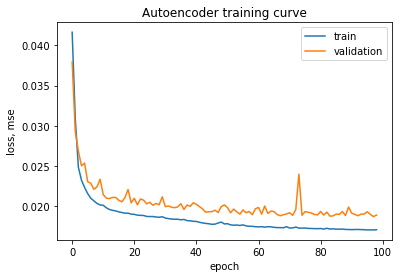

In [26]:
import matplotlib.pyplot as plt
start = 1
plt.plot(history_model_one.history['loss'][start:], label='train')
plt.plot(history_model_one.history['val_loss'][start:], label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss, mse')
plt.title('Autoencoder training curve')
plt.show()

### Load in pre-trained encoder model 

In [29]:
! ls ./checkpoints

model_01


In [30]:
model_name = "model_01"
epoch = 100
path_to_model = f'./checkpoints/{model_name}/{epoch:04d}.ckpt'
autoencoder = tf.keras.models.load_model(path_to_model)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 600, 3)]          0         
_________________________________________________________________
encoder (Functional)         (None, 100)               335972    
_________________________________________________________________
decoder (Functional)         (None, 600, 3)            334307    
Total params: 670,279
Trainable params: 667,975
Non-trainable params: 2,304
_________________________________________________________________


### Get encoder 

In [31]:
encoder_input = autoencoder.get_layer('encoder_input')
encoder = autoencoder.get_layer('encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 600, 3)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 600, 32)      704         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 600, 32)      128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 600, 32)      0           batch_normalization[0][0]        
____________________________________________________________________________________________

### Data pre-processing for Barlow-twins input
1. Strat from the grouped waveforms
2. Pair up each of the waveforms

In [87]:
train_set_bt = train_set.copy()

In [88]:
import itertools
def pair_up_waveform(waves):
    
    # ---- count number of entries
    num_entries = waves.shape[0]
    
    # ---- create pair of two
    pair_index = list(set(itertools.combinations(np.arange(num_entries),2)))
    pair_index = np.asarray(pair_index).T
    
    return pair_index

In [89]:
# ----- create indexes of pair of two
train_set_bt["pair_index"] = train_set["P_wave_processed"].apply(lambda x: pair_up_waveform(x))
train_set_bt["num_pairs"] = train_set["num_waves"].apply(lambda x: int(comb(x,2)))

num_of_pairs = train_set_bt.num_pairs.sum()
print(f"total number of pairs: {num_of_pairs}")
num_of_events = len(train_set_bt)
print(f"total number of events: {num_of_events}")

total number of pairs: 10061755
total number of events: 1034


In [95]:
# ----- now we can populate waveform pairs to numpy arrays
# set a max number of pair per event, if memory is an issue
max_num_pair = 100
total_pairs = num_of_events * max_num_pair

waves_one = np.zeros((total_pairs, 600, 3))
waves_two = np.zeros((total_pairs, 600, 3))

counter = 0
for i in range(len(train_set_bt)):
    
    indexes_for_waves_one = train_set_bt.iloc[i].pair_index[0]
    indexes_for_waves_two = train_set_bt.iloc[i].pair_index[1]
    
    if len(indexes_for_waves_one) > max_num_pair:
        indexes_for_waves_one = indexes_for_waves_one[0:max_num_pair]
        indexes_for_waves_two = indexes_for_waves_one[0:max_num_pair]
    
    num_of_combs = len(indexes_for_waves_one) + counter
    
    # ---- get waves and put into the pre-instatiiated np arrays
    waves_one[counter:num_of_combs,:,:] = train_set_bt.iloc[i]["P_wave_processed"][indexes_for_waves_one,:,:]
    waves_two[counter:num_of_combs,:,:] = train_set_bt.iloc[i]["P_wave_processed"][indexes_for_waves_two,:,:]
    
    counter = num_of_combs
    
waves_one = waves_one[:counter,:,:]
waves_two = waves_one[:counter,:,:]

### Barlow-twins part starts here

Inputs:
1. encoder : pre-trained encoder model
2. waves_one : wave copy one
3. waves_two : wave copy two

In [ ]:
plt.plot(wave[:,0])
plt.xlabel('sample 20 psp')
plt.ylabel('normalized amplitude')
plt.title('E-W motion')

In [ ]:
plt.plot(wave[:,1])
plt.xlabel('sample 20 psp')
plt.ylabel('normalized amplitude')
plt.title('N-S motion')

In [ ]:
plt.plot(wave[:,2])
plt.xlabel('sample 20 psp')
plt.ylabel('normalized amplitude')
plt.title('Vertical motion')